In [1]:
%cd ..

/home/tk/repos/explicit-memory


In [30]:
memory_order = ["episodic", "semantic", "both", "both_presem"]

max_history = 1024

legend_order = [
    "Hand-crafted 1: Only episodic",
    "Hand-crafted 2: Only semantic",
    "Hand-crafted 3: Both epi and sem",
    "Hand-crafted 4: Both epi and pre-sem",
]

color_order = ["orange", "dodgerblue", "yellowgreen", "deeppink"]

# should be "no_random", "only_random", or "somewhat_random"
policy = "no_random"

paths = "./training-results/*/train-hand-crafted.json"


In [31]:
from memory.utils import read_json
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
import numpy as np


In [32]:
def what_policy(config):
    policies = list(
        set(
            [
                val_
                for key, val in config["policy"].items()
                for key_, val_ in val.items()
            ]
        )
    )
    if "random" not in policies:
        return "no_random"

    if (
        config["memory_type"] != "both"
        and config["policy"][config["memory_type"]]["forget"] == "random"
        and config["policy"][config["memory_type"]]["answer"] == "random"
    ):
        return "only_random"

    if (
        config["memory_type"] == "both"
        and len(list(set(policies))) == 1
        and list(set(policies))[0] == "random"
    ):
        return "only_random"

    else:
        return "somewhat_random"


configs = {path: read_json(path) for path in tqdm(glob(paths))}
print(f"number of configs before parsing: {len(configs)}")

configs = {
    path: config
    for path, config in configs.items()
    if config["max_history"] == max_history and what_policy(config) == policy
}
print(f"number of matching ({policy}) configs: {len(configs)}")

results_raw = {
    path: read_json(path.replace("train-hand-crafted", "results"))
    for path, config in tqdm(configs.items())
}

print(f"number of loaded results {policy}: {len(results_raw)}")


  0%|          | 0/2000 [00:00<?, ?it/s]

number of configs before parsing: 2000
number of matching (no_random) configs: 200


  0%|          | 0/200 [00:00<?, ?it/s]

number of loaded results no_random: 200


In [33]:
results = {key: [] for key in memory_order}
seeds = []
capacities = []
for key, result in results_raw.items():
    memory_type = result["memory_type"]
    capacity = result["capacity"]["episodic"] + result["capacity"]["semantic"]
    rewards = {split: result[split]["rewards"] for split in ["train", "val", "test"]}

    seed = result["seed"]
    seeds.append(seed)
    capacities.append(capacity)

    to_append = {"capacity": capacity, "rewards": rewards, "seed": seed}

    if result["memory_type"] == "episodic":
        results["episodic"].append(to_append)
    elif result["memory_type"] == "semantic":
        results["semantic"].append(to_append)
    elif result["memory_type"] == "both" and (not result["pretrain_semantic"]):
        results["both"].append(to_append)
    elif result["memory_type"] == "both" and (result["pretrain_semantic"]):
        results["both_presem"].append(to_append)
    else:
        raise ValueError

assert len(set(list((dict(Counter(seeds)).values())))) == 1
seeds = set(seeds)

print("before averaging seeds:")
for key, val in results.items():
    print(key, len(val))

capacities = sorted(list(set(capacities)))


def rewards2acc(rewards):
    return {key: val / max_history for key, val in rewards.items()}


def get_mean_std(list_of_accs):
    nums = {
        split: [acc[split] for acc in list_of_accs]
        for split in ["train", "val", "test"]
    }
    means = {split: np.mean(nums[split]) for split in ["train", "val", "test"]}
    stds = {split: np.std(nums[split]) for split in ["train", "val", "test"]}
    num_samples = {split: len(nums[split]) for split in ["train", "val", "test"]}

    return {"means": means, "stds": stds, "num_samples": nums}


results = {
    key: {
        capacity: get_mean_std(
            [
                rewards2acc(val_["rewards"])
                for val_ in val
                if val_["capacity"] == capacity
            ]
        )
        for capacity in capacities
    }
    for key, val in results.items()
}


before averaging seeds:
episodic 50
semantic 50
both 50
both_presem 50


In [34]:
memory_order

['episodic', 'semantic', 'both', 'both_presem']

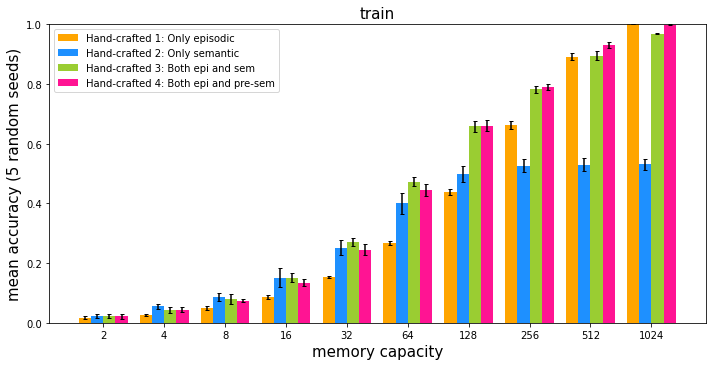

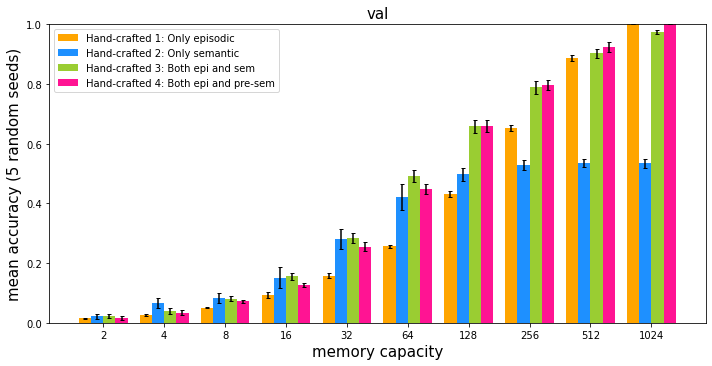

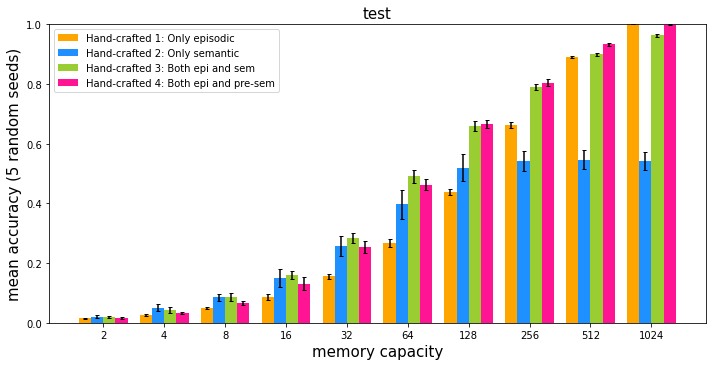

In [35]:
for split in ["train", "val", "test"]:
    capacities = list(results["episodic"])

    fig, ax = plt.subplots(figsize=(10, 5))

    idx = np.asanyarray([i for i in range(len(capacities))])

    width = 0.2

    for memory_type, w, color in zip(memory_order, [-1.5, -0.5, 0.5, 1.5], color_order):
        means = [
            val["means"][split] for key, val in sorted(results[memory_type].items())
        ]
        stds = [val["stds"][split] for key, val in sorted(results[memory_type].items())]

        ax.bar(
            x=idx + w * width,
            height=means,
            yerr=stds,
            width=width,
            color=color,
            capsize=2
        )
    ax.set_xticks(idx)
    ax.set_xticklabels(capacities)
    ax.legend(legend_order, fontsize=10, loc="upper left")
    ax.set_xlabel("memory capacity", fontsize=15)
    ax.set_ylabel(f"mean accuracy ({len(seeds)} random seeds)", fontsize=15)

    ax.set_ylim([0, 1])

    fig.tight_layout()
    plt.title(split, fontsize=15)
    plt.savefig("./figures/" + split + "-bar.pdf", bbox_inches="tight")
    plt.show()
